In [78]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import scipy.stats as si
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import datetime
import matplotlib.pyplot as plt

In [2]:
def get_date_range(df,start_date, end_date):
    mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
    return mask

In [3]:
consum = pd.read_csv("FilecoinGreenEnergyConsumption-FilecoinGreenEnergyConsumption.csv", 
                          parse_dates = ['Date'])
# removing timezone for plotting
consum["Date"] = consum["Date"].apply(lambda x: x.replace(tzinfo=None))
consum.head()

,Date,Data storage capacity,Data storage capacity added per day,Cumulative renewable energy purchases,Energy intensity lower bound,Energy intensity estimate,Energy intensity upper bound,Energy consumption rate lower bound,Energy consumption rate estimate,Energy consumption rate upper bound,Energy used to seal data lower bound,Energy used to seal data estimate,Energy used to seal data upper bound,Cumulative energy use lower bound,Cumulative energy use estimate,Cumulative energy use upper bound,Energy used to store data lower bound,Energy used to store data estimate,Energy used to store data upper bound
0,2020-08-24,498448,2053024,15734658.47,1404.098113,10618.245610,21402.982540,651.804634,4929.158175,9935.604259,551.893912,3137.985593,5143.64633,15643.17893,1.182999e+05,2.384543e+05,0.482896,1.605601,4.335152
1,2020-08-25,9237744,13984256,16020743.17,516.832219,3906.016457,7877.754829,4446.472725,33604.707650,67774.841940,3759.247698,21374.515770,35036.15498,122357.62330,9.248137e+05,1.865049e+06,8.949526,29.756621,80.343431
2,2020-08-26,22553828,13212864,16306827.87,200.762976,1514.930303,3059.685608,4217.004054,31820.943110,64268.357070,3551.882100,20195.466240,33103.50947,223564.86940,1.688517e+06,3.407488e+06,21.850149,72.650391,196.157408
3,2020-08-27,36361328,14277536,16592912.57,134.966149,1017.172660,2056.697582,4570.510617,34445.662720,69648.265260,3838.087228,21822.785450,35770.93869,333256.20430,2.515214e+06,5.079045e+06,35.226855,117.127110,316.245378
4,2020-08-28,51427203,16174560,16878997.27,108.350558,815.823835,1650.977121,5189.484114,39074.139640,79074.069440,4348.045219,24722.329720,40523.74262,457802.78090,3.452994e+06,6.976821e+06,49.822674,165.657306,447.277813


In [4]:
filusd = pd.read_csv("FIL-USD-FIL-USD.csv", parse_dates = ['Date'])
filusd['Log Returns'] = np.log(filusd['Adj Close']/filusd['Adj Close'].shift(1))
filusd_relevant = filusd[["Date","Adj Close",'Log Returns']]
filusd_relevant = filusd_relevant.rename({"Adj Close": "FIL Price"}, axis=1)

In [5]:
# Data for USA electricity prices: https://data.bls.gov/timeseries/APU000072610?amp%253bdata_tool=XGtable&output_view=data&include_graphs=true
elec_prices = pd.read_excel("usa_electricity_prices.xlsx", sheet_name="DF Format", parse_dates= ["Date"]) # I manually transposed the data
elec_prices.head()

,Date,Electricity Price
0,2020-01-01,0.134
1,2020-02-01,0.134
2,2020-03-01,0.134
3,2020-04-01,0.133
4,2020-05-01,0.134


In [6]:
# adding dummy date for December 2022 so the prices can fill up in the subsequent steps.
new_row = pd.DataFrame({"Date": datetime.datetime(2022,12,1,0,0,0), "Electricity Price": 0.0}, index = [len(elec_prices)])
elec_prices = elec_prices.append(new_row)

In [7]:
# filling all dates with prices, expanded monthly prices to daily prices. Assume price is constant through the month.
elec_prices.set_index("Date", inplace = True)
elec_prices = elec_prices.resample('D').first().ffill()
elec_prices = elec_prices.reset_index(drop= False)
elec_prices.head()

,Date,Electricity Price
0,2020-01-01,0.134
1,2020-01-02,0.134
2,2020-01-03,0.134
3,2020-01-04,0.134
4,2020-01-05,0.134


In [8]:
# removed additional december data since all info is filled
elec_prices = elec_prices[:-1]
elec_prices["Date"] = elec_prices["Date"].apply(lambda x: x.replace(tzinfo=None))

In [9]:
(consum[0:1]["Date"], consum[-1:]["Date"]) # getting the date range

(0   2020-08-24
 Name: Date, dtype: datetime64[ns],
 783   2022-10-16
 Name: Date, dtype: datetime64[ns])

In [10]:
# getting relevant dates for electricity prices
elec_prices_relevant = elec_prices[get_date_range(elec_prices, "2020-08-24", "2022-10-16")] 

In [11]:
final_df = pd.DataFrame(consum["Date"])

In [12]:
final_df = final_df.merge(consum[["Date", "Data storage capacity added per day"]], on ="Date")
final_df = final_df.merge(elec_prices_relevant, on="Date")
final_df = final_df.merge(filusd_relevant, on="Date")

In [13]:
final_df.head()

,Date,Data storage capacity added per day,Electricity Price,FIL Price,Log Returns
0,2020-08-24,2053024,0.137,22.020189,0.072989
1,2020-08-25,13984256,0.137,22.193523,0.007841
2,2020-08-26,13212864,0.137,21.462585,-0.033489
3,2020-08-27,14277536,0.137,22.159378,0.031950
4,2020-08-28,16174560,0.137,24.273489,0.091124


In [15]:
final_df[["Electricity Price", "Data storage capacity added per day", "FIL Price"]].corr()

,Electricity Price,Data storage capacity added per day,FIL Price
Electricity Price,1.000000,-0.233921,-0.464394
Data storage capacity added per day,-0.233921,1.000000,0.583667
FIL Price,-0.464394,0.583667,1.000000


In [ ]:
# Hypothesis: Data Storage Capacity added per day is dependent on the price of FIL & cost of electricity. 
# Miners are tied down to deals that require them to provide storage for a specified amount of time.
# Thus, a miner can only decide to stop adding Storage Capacity once the deal expires OR 
# if they completely decide to abandon the deal. I would assume that the latter (if chosen done) would 
# be reviewed on a weekly basis. Deals are minimum of 180 Days, so assuming the former is infeasible with
# the limited data on hand.

# ie; Higher the price of FIL (from 7 days ago), SP is more likely to add storage since more revenue is generated
# ie; Higher the price of electricity (from 7 days ago), SP is less likely to add storage since its costlier to do so.
# A simple formula would be: a*priceOfFIL(t-7) - b*priceOfElectricity(t-7) = Data Storage Capacity added per day(time = t)

In [34]:
final_df["Electricity Price 7 Days Prior"] = final_df["Electricity Price"].shift(7)
final_df["FIL Price 7 Days Prior"] = final_df["FIL Price"].shift(7)

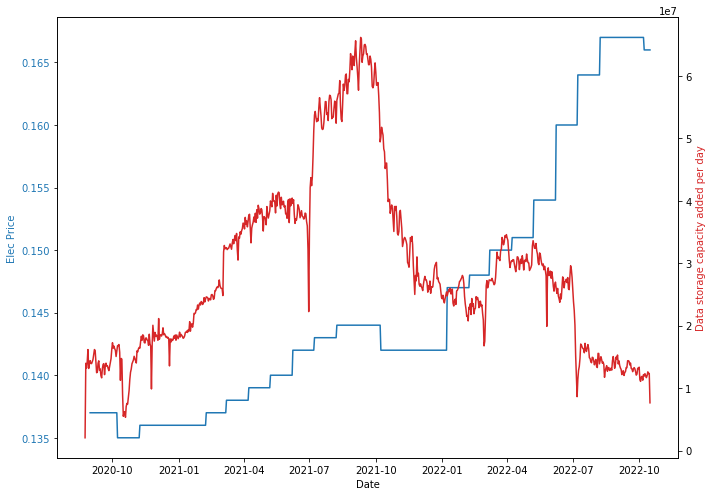

In [35]:
fig, ax1 = plt.subplots(figsize=(10,7))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Elec Price', color=color)
ax1.plot(final_df['Date'], final_df["Electricity Price 7 Days Prior"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Data storage capacity added per day', color=color)  # we already handled the x-label with ax1
ax2.plot(final_df['Date'], final_df['Data storage capacity added per day'], color=color)

fig.tight_layout()

plt.show()


Text(0, 0.5, 'Data storage capacity added per day')

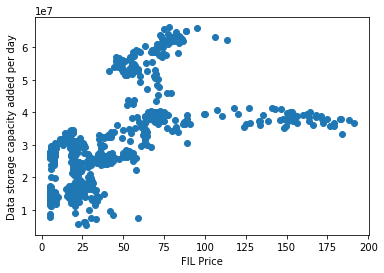

In [36]:
plt.scatter(x=final_df["FIL Price 7 Days Prior"], y=final_df['Data storage capacity added per day'])
plt.xlabel("FIL Price") #x label
plt.ylabel("Data storage capacity added per day") #y label

Text(0, 0.5, 'Data storage capacity added per day')

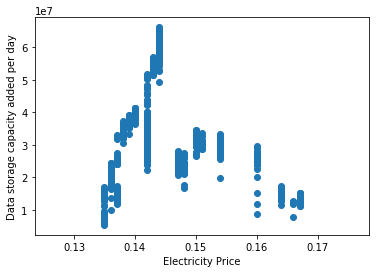

In [38]:
plt.scatter(x=final_df["Electricity Price 7 Days Prior"], y=final_df['Data storage capacity added per day'])
plt.xlabel("Electricity Price") #x label
plt.ylabel("Data storage capacity added per day") #y label

In [60]:
final_df_dropped = final_df.dropna(how= "all")

In [61]:
X_train, X_test, y_train, y_test = train_test_split(final_df_dropped[["Electricity Price", "FIL Price"]], final_df_dropped["Data storage capacity added per day"], test_size=0.20, shuffle=False)

In [64]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

LinearRegression()

In [65]:
y_pred = regressor.predict(X_test)

In [68]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten()})
df

,Actual,Predicted
627,31479680,3.814396e+07
628,30097664,3.816210e+07
629,29777728,3.823757e+07
630,31650496,3.804624e+07
631,31421536,3.811095e+07
...,...,...
779,11987424,5.227223e+07
780,12611296,5.227052e+07
781,12329664,5.225550e+07
782,12360032,5.228067e+07


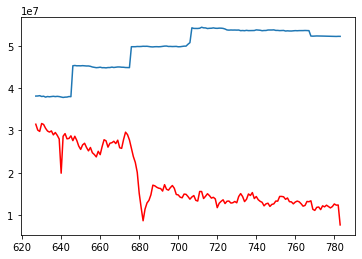

In [74]:
plt.plot(df["Predicted"])
plt.plot(df["Actual"], color="red")
plt.show()

In [79]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


Mean Absolute Error: 31105557.833508827
Mean Squared Error: 1104905958162077.8
Root Mean Squared Error: 33240125.72422189


In [ ]:
# Absolutely horrible results but I did not have the time to further look into other ML algorithms such an LSTM with some Time Series Forecasting.